# Assigment 2. Graphical monitoring and overfitting
## Objectives
The objectives of this assignment are:

1. to try out different model architectures
2. to experiment with different kinds of regularization

## Overfittet model

In [3]:
import os

import matplotlib.pyplot as plt
from keras import Input, regularizers
from keras import Sequential
from keras.callbacks import EarlyStopping
from keras.datasets import california_housing
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

(inputs, targets), (x_test, y_test) = california_housing.load_data(version='large',
                                                                   test_split=0.2)
print(inputs.shape, targets.shape)
print(x_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


In [4]:
# split train set to validation and  actual trainset
x_train, x_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=42)



Next, we standardize the input features by subtracting the mean and dividing by the standard deviation. Note that only the training set is used to estimate the mean and standard deviation in the dataset; both the validation set and the test set are then also standardized using these values. In addition, we divide the target variable (house prize in dollars) by 100000, in order to obtain values on the order of unity.

In [5]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)
x_train -= mean
x_train /= std
x_test -= mean
x_test /= std
x_val -= mean
x_val /= std
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

After this simple preprocessing, we are ready to construct a neural network model for treating the regression problem for the above data.

At the start there is two dense layers with 64 neurons and it seems that model is overfitting with that setup, so it is time to experiment with some of the parameters and optimizers.

In [706]:
# define the model architecture
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

# configure the learning algorithm
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0)


Text(0, 0.5, 'Loss')

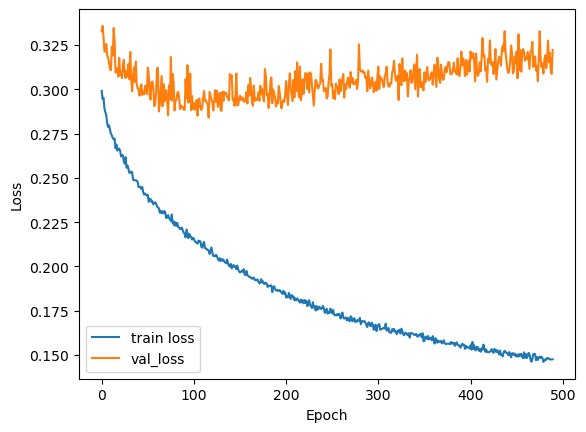

In [707]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

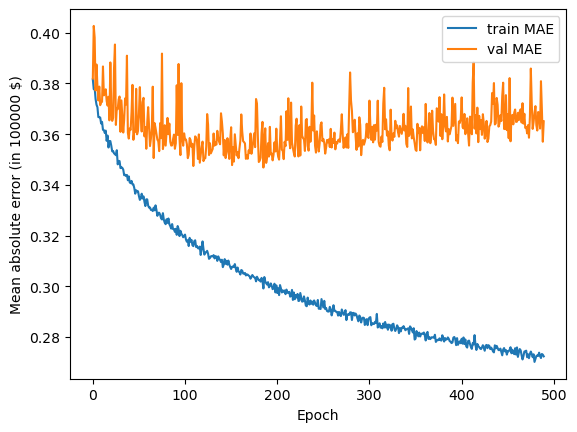

In [708]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

In [723]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')
print(f'Test loss : {test_loss:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2782 - mae: 0.3546
Test mean absolute error: 0.3546
Test loss : 0.2782


## Improving the model

Adding drop out decreased overfitting enormously

In [710]:
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dropout(0.2),  # drop 20% of the outputs
    Dense(64, activation='relu'),
    Dropout(0.2),  # drop 20% of the outputs
    Dense(1)
])

# configure the learning algorithm
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=0)

Text(0, 0.5, 'Loss')

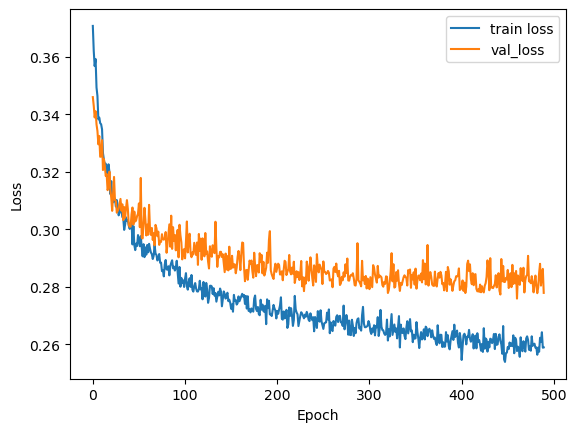

In [711]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

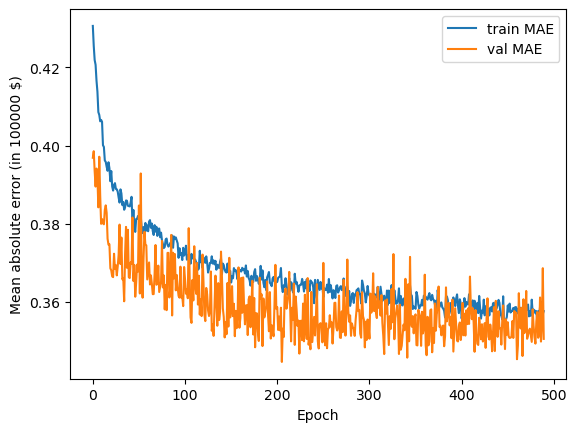

In [712]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

In [722]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')
print(f'Test loss : {test_loss:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2782 - mae: 0.3546
Test mean absolute error: 0.3546
Test loss : 0.2782


Adding early stopping and reducing learning rate increased model learning

In [714]:
model = Sequential([
    Input(shape=(8,)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])
optimizer = Adam(learning_rate=0.00009)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=500, batch_size=128, validation_data=(x_val, y_val), verbose=0,
                    callbacks=[early_stop])

Text(0, 0.5, 'Loss')

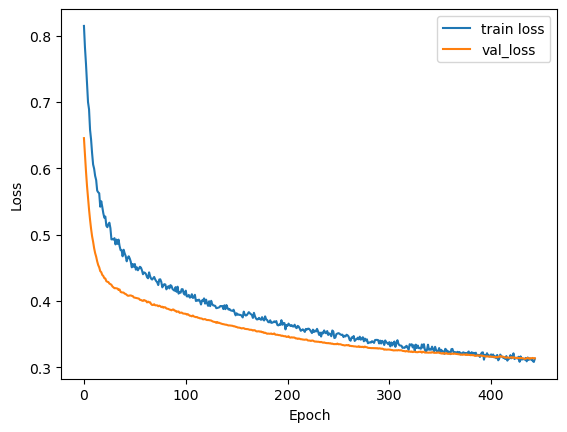

In [715]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

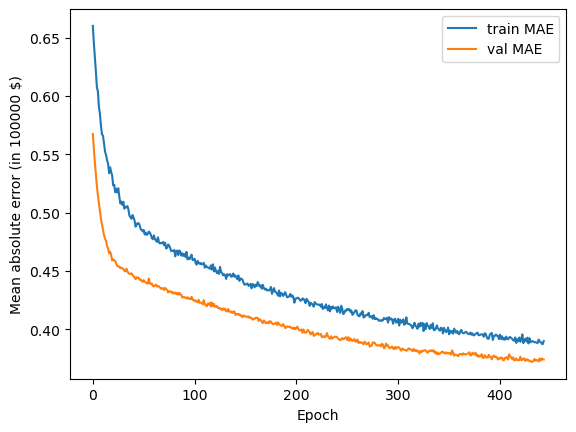

In [716]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

In [717]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2999 - mae: 0.3726
Test mean absolute error: 0.3726


Next I started to combine and test different ways to improve learning. Full trainset is also combined from old validation and trainset. Finally I ended up adding batch normalization and regualizers which evened learning process so validation and test plots are in even form. Adding those also speeded up training a little pit. I also noticed that batch size did not affect much on learning so i adjusted it to 64 to speed things up. I also modified layers from previous run by decreasing 2nd layer neurons from 64 -> 32 and adding third 16 neuron layer.

In [7]:
import numpy as np
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Activation
from keras.layers import BatchNormalization

x_train_full = np.concatenate((x_train, x_val), axis=0)  # join train + val sets
y_train_full = np.concatenate((y_train, y_val), axis=0)

model = Sequential([
    Input(shape=(8,)),
    Dense(64, kernel_regularizer=regularizers.l2(1e-6)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, kernel_regularizer=regularizers.l2(1e-6)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(16, kernel_regularizer=regularizers.l2(1e-5)),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0003)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=0)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history = model.fit(
    x_train, y_train,
    epochs=800,
    batch_size=64,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stop]
)


### 📊 Test Results
- **MAE:** 0.3546 → ≈ 35 460 $
- **MSE:** 0.2782
- Model stopped at **epoch 325 / 800**, achieving similar accuracy to the full 500-epoch run.
- The combination of early stopping, adaptive learning rate scheduling and  modifying layers (dropout,density,L2 regularization) improved model stability and reduced training time by approximately 35%.



Text(0, 0.5, 'Loss')

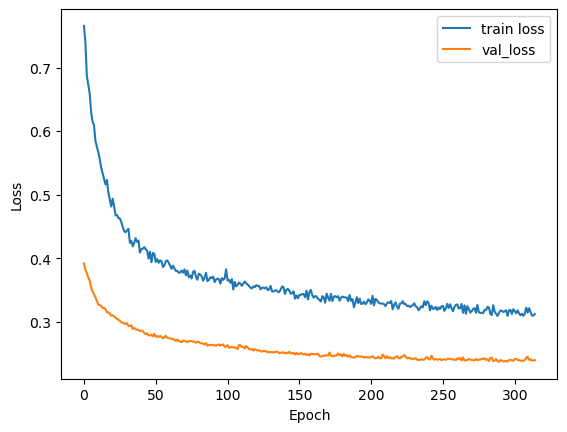

In [719]:
plt.plot(history.history['loss'][10:], label='train loss')
plt.plot(history.history['val_loss'][10:], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Mean absolute error (in 100000 $)')

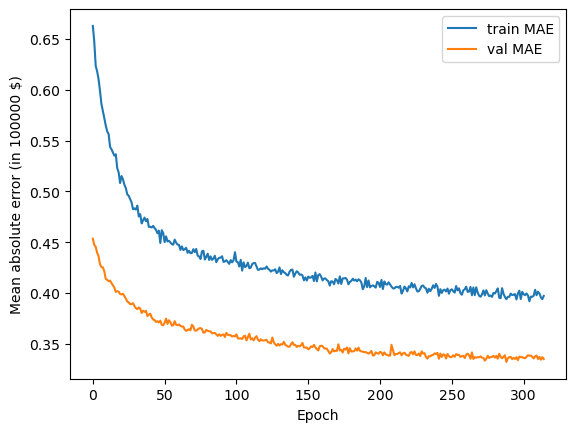

In [720]:
plt.plot(history.history['mae'][10:], label='train MAE')
plt.plot(history.history['val_mae'][10:], label='val MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error (in 100000 $)')

In [721]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test mean absolute error: {test_mae:.4f}')
print(f'Test loss : {test_loss:.4f}')

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2782 - mae: 0.3546
Test mean absolute error: 0.3546
Test loss : 0.2782
